## 📊 Step 1 — Generate Synthetic Dataset for Sfax

In this section, we **simulate realistic bin-filling data** for different zones of Sfax over several days.  
The goal is to create CSV files that represent how bins fill up depending on:

- **Zones** (e.g., Sfax City, Thyna, Sakiet Ezzit…)  
- **Waste types** (organic, plastic, paper, metal)  
- **Time of day patterns** (e.g., morning/evening surges)  
- **Day of the week effects** (weekend vs weekday)  
- **Block-level variability** (some blocks are “busier” than others)  

### Key Features
- Data generated at **30-minute intervals** (`FREQ = "30min"`).  
- Each bin resets (emptied) at **06:00 and 20:00**.  
- Start-of-day bin fill levels are randomized (between 10%–40%).  
- Extra multipliers for:
  - Zone-specific tendencies  
  - Waste-type differences  
  - Weekend vs weekday activity  
  - Morning and evening disposal surges  
  - Busy vs normal blocks  

### Output
For each day, the script generates a **CSV file** containing:  
- Timestamps, zone/block info, waste type  
- Fill level in liters and percentage  
- Time-based features (hour, day of week, sine/cosine encodings)  
- Indicator if the bin was emptied  

At the end, a **sanity check** prints how many bins are already ≥80% full during evening snapshots.


In [1]:
# =========================
# Sfax synthetic dataset (8 days) — tuned fill rates
# =========================

# --- Config (edit as you like) ---
START_DATE = "2025-09-02"   # first day
NUM_DAYS   = 8              # total days to generate
FREQ       = "30min"        # reporting interval
BLOCKS_PER_ZONE = 100
OUTPUT_DIR = "/content"     # e.g., "/content/drive/MyDrive/TecweekData"

# If writing to Google Drive, uncomment:
# from google.colab import drive
# drive.mount('/content/drive')

import pandas as pd
import numpy as np
from pathlib import Path

# Reproducibility
GLOBAL_SEED = 23
np.random.seed(GLOBAL_SEED)

# Zones (IDs + English names)
ZONES = [
    (1, "Sfax South"),
    (2, "Sfax City"),
    (3, "Thyna"),
    (4, "Sfax West"),
    (5, "Sakiet Ezzit"),
    (6, "Sakiet Eddaier"),
]

# Waste types and constants
WASTE_TYPES = ["organic", "plastic", "paper", "metal"]
BIN_CAP_L = 50.0
STEPS_PER_DAY = int(pd.Timedelta("1D") / pd.Timedelta(FREQ))

# Zone-type tendencies (relative multipliers)
zone_type_bias = {
    "Sfax South":     {"organic": 1.25, "plastic": 0.90, "paper": 0.90, "metal": 0.80},
    "Sfax City":      {"organic": 0.90, "plastic": 1.20, "paper": 1.30, "metal": 0.90},
    "Thyna":          {"organic": 0.70, "plastic": 1.10, "paper": 0.90, "metal": 1.30},
    "Sfax West":      {"organic": 1.00, "plastic": 1.00, "paper": 1.00, "metal": 1.00},
    "Sakiet Ezzit":   {"organic": 1.20, "plastic": 1.00, "paper": 0.90, "metal": 0.90},
    "Sakiet Eddaier": {"organic": 1.10, "plastic": 0.90, "paper": 0.90, "metal": 0.80},
}

# Waste-type base multipliers
waste_base = {"organic": 1.15, "plastic": 1.00, "paper": 0.85, "metal": 0.70}

# Weekend modifier (Saturday=5, Sunday=6)
def weekend_factor(ts, wt, zone_name):
    dow = ts.dayofweek
    if dow in (5, 6):  # Sat, Sun
        if wt in ("paper", "plastic") and zone_name == "Sfax City":
            return 0.7   # less office/shop activity
        if wt == "organic" and zone_name in ("Sfax South", "Sakiet Ezzit", "Sakiet Eddaier"):
            return 1.1   # more at-home activity
    return 1.0

# ----------------------------
# Tunable knobs (raised speeds)
# ----------------------------
FILL_SPEED = 5              # global speed multiplier (↑ for more crossings)
START_LEVEL_RANGE = (10, 40)  # start-of-day %
HEAVY_BLOCK_PROB = 0.15       # fraction of “busy” blocks
HEAVY_BLOCK_MULT = 1.35       # busy blocks fill faster
DAILY_LOAD_MEAN = 1.0         # average daily load
DAILY_LOAD_STD  = 0.20        # variability day-to-day

# Optional time-of-day surge windows (extra push at common disposal waves)
SURGE_WINDOWS = [
    (6.0,  9.0,  1.4),   # morning surge
    (17.0, 21.0, 1.5),   # evening surge
]

def tod_rate(ts):
    """Base rate in percentage points per 30min (before multipliers)."""
    h = ts.hour + ts.minute/60.0
    if 0 <= h < 5.5:   # Night very low
        base = 0.06
    elif 5.5 <= h < 10:
        base = 0.80 + 0.13 * (h - 5.5)
    elif 10 <= h < 16:
        base = 0.55
    elif 16 <= h < 21:
        base = 1.00 + 0.16 * (h - 16)
    else:
        base = 0.25
    # Apply surge windows
    surge = 1.0
    for hs, he, mult in SURGE_WINDOWS:
        if hs <= h < he:
            surge *= mult
    return base * surge

def generate_day(day_start_ts, rng_seed=None):
    """
    Generate one day's data for all zones/blocks/waste types at 30-min steps.
    Resets (empties) at 06:00 and 20:00. Uses higher fill speeds & surges.
    """
    if rng_seed is not None:
        np.random.seed(rng_seed)

    TIMES = pd.date_range(day_start_ts, periods=STEPS_PER_DAY, freq=FREQ)
    rows = []

    # Per-day load multiplier (some days heavier)
    daily_load = max(0.2, np.random.normal(DAILY_LOAD_MEAN, DAILY_LOAD_STD))

    for zone_id, zone_name in ZONES:
        # Per-block heterogeneity for the day
        block_factors = np.random.uniform(0.85, 1.25, size=BLOCKS_PER_ZONE)
        # Randomly mark some blocks as "busy"
        is_busy = np.random.rand(BLOCKS_PER_ZONE) < HEAVY_BLOCK_PROB

        for idx, block_factor in enumerate(block_factors):
            block_idx = idx + 1
            busy_mult = HEAVY_BLOCK_MULT if is_busy[idx] else 1.0

            for wt in WASTE_TYPES:
                # higher start-of-day, bins closer to 80
                current_pct = float(np.random.uniform(*START_LEVEL_RANGE))
                for t in TIMES:
                    # scheduled emptying at 06:00 and 20:00
                    emptied = 1 if ((t.hour == 6 and t.minute == 0) or (t.hour == 20 and t.minute == 0)) else 0
                    if emptied:
                        current_pct = 0.0

                    # increment based on TOD, type, zone, block, busy-ness, weekend, global speed, daily load
                    inc = (
                        FILL_SPEED
                        * tod_rate(t)
                        * waste_base[wt]
                        * zone_type_bias[zone_name][wt]
                        * block_factor
                        * busy_mult
                        * daily_load
                        * weekend_factor(t, wt, zone_name)
                    )
                    # small noise; keep non-negative increments
                    inc += np.random.normal(0, 0.12)
                    current_pct = float(np.clip(current_pct + max(0, inc), 0, 100))

                    # derived features
                    hour = t.hour + t.minute / 60.0
                    hour_rad = 2 * np.pi * (hour / 24.0)
                    dow = t.dayofweek
                    dow_rad = 2 * np.pi * (dow / 7.0)

                    rows.append({
                        "timestamp": t,
                        "zone_id": zone_id,
                        "zone_name": zone_name,
                        "block_id": block_idx,
                        "waste_type": wt,
                        "fill_level_liters": round(current_pct * BIN_CAP_L / 100.0, 2),
                        "fill_percent": round(current_pct, 2),
                        "hour": round(hour, 2),
                        "day_of_week": dow,
                        "hour_sin": np.sin(hour_rad),
                        "hour_cos": np.cos(hour_rad),
                        "dow_sin": np.sin(dow_rad),
                        "dow_cos": np.cos(dow_rad),
                        "emptied": emptied,
                    })

    return pd.DataFrame(rows)

# --- Generate and save all days ---
OUTPUT_DIR = Path(OUTPUT_DIR)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

start_ts = pd.Timestamp(START_DATE)
paths = []
for d in range(NUM_DAYS):
    day_start = start_ts + pd.Timedelta(days=d)
    df_day = generate_day(day_start_ts=day_start, rng_seed=GLOBAL_SEED + d)
    out_path = OUTPUT_DIR / f"sfax_synthetic_day{d+1}.csv"
    df_day.to_csv(out_path, index=False)
    paths.append(str(out_path))

print("Generated files:")
for p in paths:
    print("  -", p)

# --- Quick sanity: evening snapshot share >=80% (should be >0 if speeds are OK) ---
snap = df_day[df_day["timestamp"].dt.strftime("%H:%M").isin(["18:00","19:00","20:00"])]
print("Evening snapshot (day", NUM_DAYS, ") share ≥80%:",
      round((snap["fill_percent"]>=80).mean()*100, 2), "%")


Generated files:
  - /content/sfax_synthetic_day1.csv
  - /content/sfax_synthetic_day2.csv
  - /content/sfax_synthetic_day3.csv
  - /content/sfax_synthetic_day4.csv
  - /content/sfax_synthetic_day5.csv
  - /content/sfax_synthetic_day6.csv
  - /content/sfax_synthetic_day7.csv
  - /content/sfax_synthetic_day8.csv
Evening snapshot (day 8 ) share ≥80%: 49.29 %


## 📥 Step 2 — Load & Prepare Data

- Load 8 daily CSV files into one DataFrame.  
- Encode **zones (6)** and **waste types (4)** as one-hot vectors.  
- Build sliding windows: **12 past steps (6h) → 12 future steps (6h)**.  
- Exclude sequences that contain **emptying events** (06:00 / 20:00).  

**Result:**  
- `X` → shape `(N, 12, 15)` with features  
- `y` → shape `(N, 12)` with future fill %  
- Metadata (zone, block, waste type, start time) kept separately.


In [2]:
# =========================
# Load data
# =========================
import pandas as pd, numpy as np
from pathlib import Path

DATA_DIR = Path("/content")  # adjust if you saved elsewhere
files = [DATA_DIR/f"sfax_synthetic_day{i}.csv" for i in range(1,9)]
df = pd.concat([pd.read_csv(p, parse_dates=["timestamp"]) for p in files], ignore_index=True)
df = df.sort_values(["zone_id","block_id","waste_type","timestamp"]).reset_index(drop=True)

# One-hot maps
zone_ids = sorted(df["zone_id"].unique())          # [1..6]
type_names = ["organic","plastic","paper","metal"]
zone_map = {z:i for i,z in enumerate(zone_ids)}
type_map = {t:i for i,t in enumerate(type_names)}
Z, T = len(zone_ids), len(type_names)

# =========================
# Build sequences (12→12) — excludes windows with emptying inside
# =========================
hist, horizon = 12, 12
feat_cols = ["fill_percent","hour_sin","hour_cos","dow_sin","dow_cos"]

X_list, y_list, meta_list = [], [], []

def has_inside_emptying(series, left, right):
    if right - left + 1 <= 2: return False
    return series.iloc[left+1:right].any()

ng = df.groupby(["zone_id","block_id","waste_type"]).ngroups
print("Total series:", ng)

for (zid, bid, wt), g in df.groupby(["zone_id","block_id","waste_type"], sort=False):
    g = g.sort_values("timestamp").reset_index(drop=True)
    n = len(g)
    if n < hist + horizon:
        continue

    z_oh = np.eye(Z)[zone_map[zid]]
    t_oh = np.eye(T)[type_map[wt]]

    for i in range(hist, n - horizon):
        hist_idx = range(i - hist, i)       # 12 past
        fut_idx  = range(i, i + horizon)    # 12 future

        if has_inside_emptying(g["emptied"], i - hist, i - 1): continue
        if has_inside_emptying(g["emptied"], i, i + horizon - 1): continue

        X_num = g.iloc[hist_idx][feat_cols].to_numpy(float)  # (12,5)
        if X_num.shape[0] != hist: continue

        z_rep = np.tile(z_oh, (hist, 1))   # (12,6)
        t_rep = np.tile(t_oh, (hist, 1))   # (12,4)
        X_win = np.concatenate([X_num, z_rep, t_rep], axis=1)  # (12,15)

        y_win = g.iloc[fut_idx]["fill_percent"].to_numpy(float)  # (12,)
        if y_win.shape[0] != horizon: continue

        X_list.append(X_win)
        y_list.append(y_win)
        meta_list.append({
            "zone_id": zid, "block_id": bid, "waste_type": wt,
            "start_time": g.loc[i, "timestamp"]
        })

X = np.array(X_list)  # (N,12,15)
y = np.array(y_list)  # (N,12)
print("Sequences:", X.shape, y.shape)


Total series: 2400
Sequences: (187200, 12, 15) (187200, 12)


## ⚖️ Step 3 — Scaling & Train/Validation Split

- Apply **MinMaxScaler** only to `fill_percent` (0–1 range).  
- Keep all other features unchanged.  
- Use **first 7 days** for training, and **Day 8** (from 2025-09-09) for validation.  

**Result:**  
- `X_train`, `y_train` → training sequences  
- `X_val`, `y_val` → validation sequences


In [3]:
# =========================
# Scale ONLY fill_percent (col 0), split by time (Day 8 for val)
# =========================
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

scaler = MinMaxScaler()
flat_hist = X[:,:,0].reshape(-1,1)     # (N*12,1)
scaler.fit(flat_hist)

X_scaled = X.copy()
X_scaled[:,:,0] = scaler.transform(flat_hist).reshape(X.shape[0], X.shape[1])
y_scaled = scaler.transform(y.reshape(-1,1)).reshape(y.shape)

meta_df = pd.DataFrame(meta_list)
split_time = pd.Timestamp("2025-09-09")     # day 8 starts
is_val = meta_df["start_time"] >= split_time

X_train, X_val = X_scaled[~is_val.values], X_scaled[is_val.values]
y_train, y_val = y_scaled[~is_val.values], y_scaled[is_val.values]
print("Train:", X_train.shape, y_train.shape, "| Val:", X_val.shape, y_val.shape)




Train: (168000, 12, 15) (168000, 12) | Val: (19200, 12, 15) (19200, 12)


## 🤖 Step 4 — LSTM Forecasting Model

- Build a **Sequential LSTM model** with:
  - Input: past 12 steps × 15 features  
  - LSTM layer (64 units)  
  - Dense hidden layer (64, ReLU)  
  - Output layer: 12 future fill % values  

- Compile with **Adam optimizer** and **MAE loss**.  
- Train for **30 epochs** with batch size 256.  
- Validate on Day 8 sequences.


In [4]:
# =========================
# LSTM model
# =========================
import tensorflow as tf
from tensorflow.keras import layers, models

hist_len, n_feat, horizon = X_train.shape[1], X_train.shape[2], y_train.shape[1]

model = models.Sequential([
    layers.Input(shape=(hist_len, n_feat)),
    layers.LSTM(64),
    layers.Dense(64, activation="relu"),
    layers.Dense(horizon)  # 12-step regression
])
model.compile(optimizer="adam", loss="mae")

history_obj = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30, batch_size=256, verbose=1
)


Epoch 1/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - loss: 0.1322 - val_loss: 0.0669
Epoch 2/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.0374 - val_loss: 0.0621
Epoch 3/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.0342 - val_loss: 0.0592
Epoch 4/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.0326 - val_loss: 0.0632
Epoch 5/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.0318 - val_loss: 0.0554
Epoch 6/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0314 - val_loss: 0.0519
Epoch 7/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.0309 - val_loss: 0.0525
Epoch 8/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.0308 - val_loss: 0.0552
Epoch 9/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - loss: 0.0304 - val_loss: 0.0563
Epoch 10/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - loss: 0.0300 - val_loss: 0.0539
Epoch 11/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - loss: 0.0294 - val_loss: 0.0493
Epoch 12/30
657/657 ━━━━━━━━━━

## ✅ Step 5 — Evaluate the Model

This function reports three views of quality:

- **Regression:** MAE, RMSE, R², MAPE (after inverse-scaling to %).
- **Classification (@ ≥80%):** confusion matrix + precision/recall/F1.
- **Event timing:** error (in 30-min steps and minutes) for the **first time** the forecast crosses the threshold.

It also draws a confusion-matrix heatmap and (optionally) prints **per-waste-type** positive F1/precision/recall using `meta_df`/`is_val`.

Run:
```python
evaluate_model(model, X_val, y_val, scaler, meta_df=meta_df, is_val=is_val, thr=80)


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    r2_score, mean_absolute_percentage_error,
    confusion_matrix, classification_report
)

def evaluate_model(model, X_val, y_val, scaler, meta_df=None, is_val=None, thr=80):
    """
    Prints:
      • Regression: MAE, RMSE, R², MAPE
      • Classification (≥thr%): confusion matrix + precision/recall/F1
      • Event timing: first-crossing timing error stats
    Also draws a confusion-matrix heatmap.
    """
    # 1) Predict + inverse-scale
    y_pred = model.predict(X_val, verbose=0)                    # (N, H)
    y_pred_pct = scaler.inverse_transform(y_pred)               # (N, H)
    y_val_pct  = scaler.inverse_transform(y_val)                # (N, H)

    # 2) Regression metrics
    mae  = np.mean(np.abs(y_pred_pct - y_val_pct))
    rmse = np.sqrt(np.mean((y_pred_pct - y_val_pct)**2))
    r2   = r2_score(y_val_pct.ravel(), y_pred_pct.ravel())
    mape = mean_absolute_percentage_error(y_val_pct.ravel(), y_pred_pct.ravel()) * 100

    print("=== REGRESSION METRICS ===")
    print(f"MAE:  {mae:.2f} %")
    print(f"RMSE: {rmse:.2f} %")
    print(f"R²:   {r2:.3f}")
    print(f"MAPE: {mape:.2f} %")

    # 3) Classification metrics (≥ thr is "positive")
    y_true_cls = (y_val_pct >= thr).astype(int).ravel()
    y_pred_cls = (y_pred_pct >= thr).astype(int).ravel()

    cm = confusion_matrix(y_true_cls, y_pred_cls)
    print("\n=== CLASSIFICATION (threshold = {}%) ===".format(thr))
    print("Confusion matrix:\n", cm)
    print("\nClassification report:\n", classification_report(
        y_true_cls, y_pred_cls, target_names=["<{}%".format(thr), "≥{}%".format(thr)]
    ))

    # 4) Event timing: first index where future crosses threshold
    def first_cross_idx(seq, threshold=thr):
        idx = np.where(seq >= threshold)[0]
        return int(idx[0]) if len(idx) else None

    true_first = [first_cross_idx(seq) for seq in y_val_pct]
    pred_first = [first_cross_idx(seq) for seq in y_pred_pct]

    both = [(p, t) for p, t in zip(pred_first, true_first) if (p is not None and t is not None)]
    timing_err = [p - t for p, t in both]  # in 30-min steps

    print("=== EVENT TIMING (first cross ≥{}%) ===".format(thr))
    print("Matched events:", len(both))
    if timing_err:
        print("Avg timing error (steps): {:.2f}".format(np.mean(timing_err)))
        print("Std timing error (steps): {:.2f}".format(np.std(timing_err)))
        print("Median timing error (steps): {:.2f}".format(np.median(timing_err)))
        # Convert to minutes (each step = 30 min)
        print("Avg timing error (minutes): {:.1f}".format(30*np.mean(timing_err)))
    else:
        print("No matched events to compute timing error.")

    missed = sum((t is not None) and (p is None) for p, t in zip(pred_first, true_first))
    false  = sum((t is None) and (p is not None) for p, t in zip(pred_first, true_first))
    print("Missed events (true crossed, predicted never):", missed)
    print("False alarms (pred crossed, true never):", false)

    # 5) Confusion matrix heatmap
    try:
        import seaborn as sns
        plt.figure(figsize=(4.5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Pred <{}%".format(thr), "Pred ≥{}%".format(thr)],
                    yticklabels=["True <{}%".format(thr), "True ≥{}%".format(thr)])
        plt.title("Confusion Matrix (≥{}%)".format(thr))
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("(Heatmap skipped: {})".format(e))

    # 6) Optional: quick glance by waste type (F1 on positives)
    if (meta_df is not None) and (is_val is not None):
        meta_val = meta_df[is_val].reset_index(drop=True)
        print("\n=== PER-WASTE-TYPE POSITIVE F1 (≥{}%) ===".format(thr))
        for wt in ["organic","plastic","paper","metal"]:
            mask = (meta_val["waste_type"]==wt).values
            if mask.sum()==0:
                continue
            y_true_m = y_true_cls.reshape(-1, y_val_pct.shape[1])[mask].ravel()
            y_pred_m = y_pred_cls.reshape(-1, y_val_pct.shape[1])[mask].ravel()
            from sklearn.metrics import f1_score, precision_score, recall_score
            pos_f1  = f1_score(y_true_m, y_pred_m, pos_label=1, zero_division=0)
            pos_p   = precision_score(y_true_m, y_pred_m, pos_label=1, zero_division=0)
            pos_r   = recall_score(y_true_m, y_pred_m, pos_label=1, zero_division=0)
            print(f"{wt:8s} → F1: {pos_f1:.3f}  (P: {pos_p:.3f}, R: {pos_r:.3f})")


=== REGRESSION METRICS ===
MAE:  1.35 %
RMSE: 2.52 %
R²:   0.991
MAPE: 3.65 %

=== CLASSIFICATION (threshold = 80%) ===
Confusion matrix:
 [[164769   1139]
 [   886  63606]]

Classification report:
               precision    recall  f1-score   support

        <80%       0.99      0.99      0.99    165908
        ≥80%       0.98      0.99      0.98     64492

    accuracy                           0.99    230400
   macro avg       0.99      0.99      0.99    230400
weighted avg       0.99      0.99      0.99    230400

=== EVENT TIMING (first cross ≥80%) ===
Matched events: 11160
Avg timing error (steps): 0.03
Std timing error (steps): 0.37
Median timing error (steps): 0.00
Avg timing error (minutes): 1.0
Missed events (true crossed, predicted never): 14
False alarms (pred crossed, true never): 521


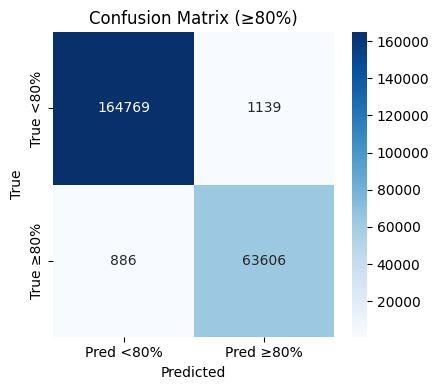


=== PER-WASTE-TYPE POSITIVE F1 (≥80%) ===
organic  → F1: 0.986  (P: 0.982, R: 0.991)
plastic  → F1: 0.988  (P: 0.993, R: 0.982)
paper    → F1: 0.982  (P: 0.978, R: 0.985)
metal    → F1: 0.962  (P: 0.948, R: 0.977)


In [6]:
evaluate_model(model, X_val, y_val, scaler, meta_df=meta_df, is_val=is_val, thr=80)


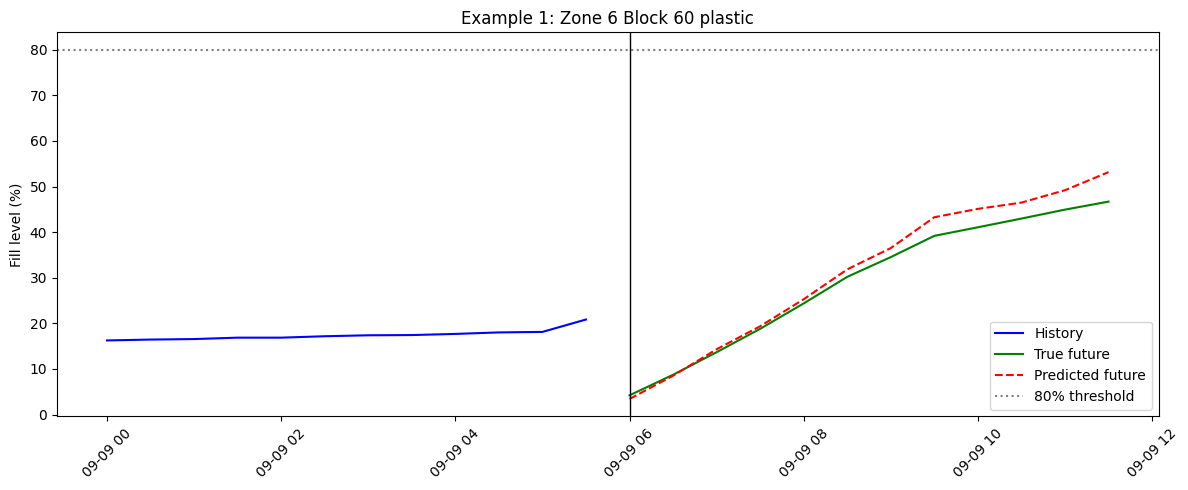

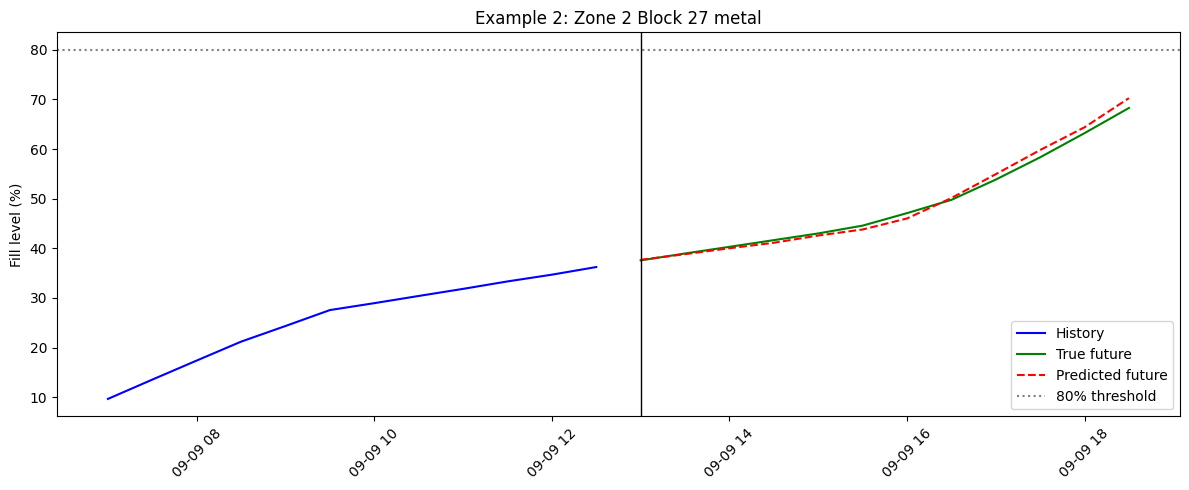

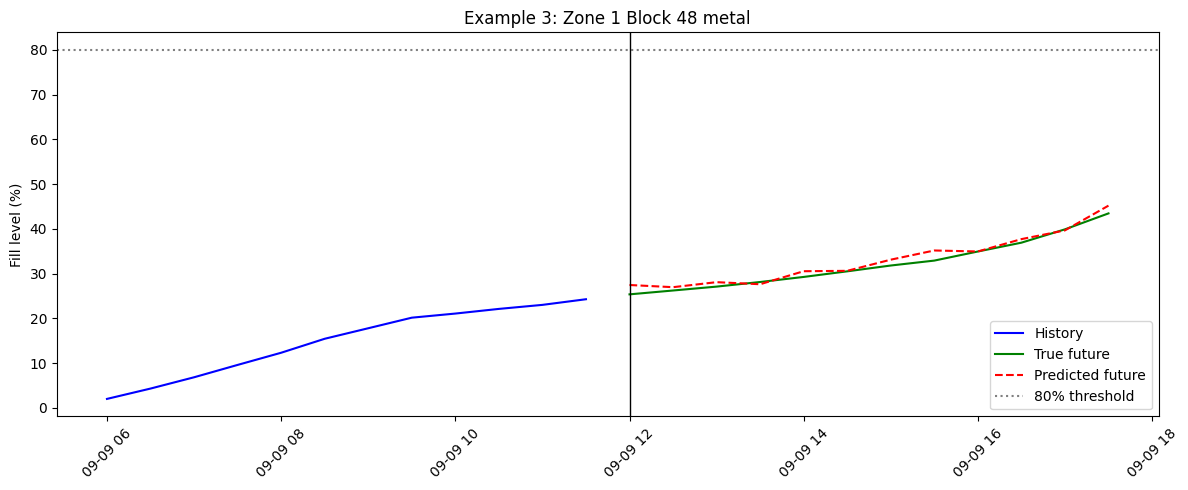

In [7]:
import matplotlib.pyplot as plt

# Pick N random examples from the validation set
N = 3
idxs = np.random.choice(len(X_val), N, replace=False)

for i, k in enumerate(idxs, start=1):
    # History (12 steps)
    hist_scaled = X_val[k,:,0].reshape(-1,1)
    hist_pct = scaler.inverse_transform(hist_scaled).ravel()

    # True future (12 steps) -> reshape
    y_true = scaler.inverse_transform(y_val[k].reshape(-1,1)).ravel()

    # Predicted future -> reshape
    y_pred = scaler.inverse_transform(
        model.predict(X_val[k:k+1], verbose=0).reshape(-1,1)
    ).ravel()

    # Time axes
    t0 = meta_df[is_val].iloc[k]["start_time"]
    times_hist = pd.date_range(t0 - pd.Timedelta(minutes=30*len(hist_pct)),
                               periods=len(hist_pct), freq="30min")
    times_fut = pd.date_range(t0, periods=len(y_true), freq="30min")

    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(times_hist, hist_pct, label="History", color="blue")
    plt.plot(times_fut, y_true, label="True future", color="green")
    plt.plot(times_fut, y_pred, "--", label="Predicted future", color="red")
    plt.axhline(80, linestyle=":", color="gray", label="80% threshold")
    plt.axvline(t0, color="black", linewidth=1)

    info = f"Zone {meta_df[is_val].iloc[k]['zone_id']} " \
           f"Block {meta_df[is_val].iloc[k]['block_id']} " \
           f"{meta_df[is_val].iloc[k]['waste_type']}"
    plt.title(f"Example {i}: {info}")
    plt.ylabel("Fill level (%)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


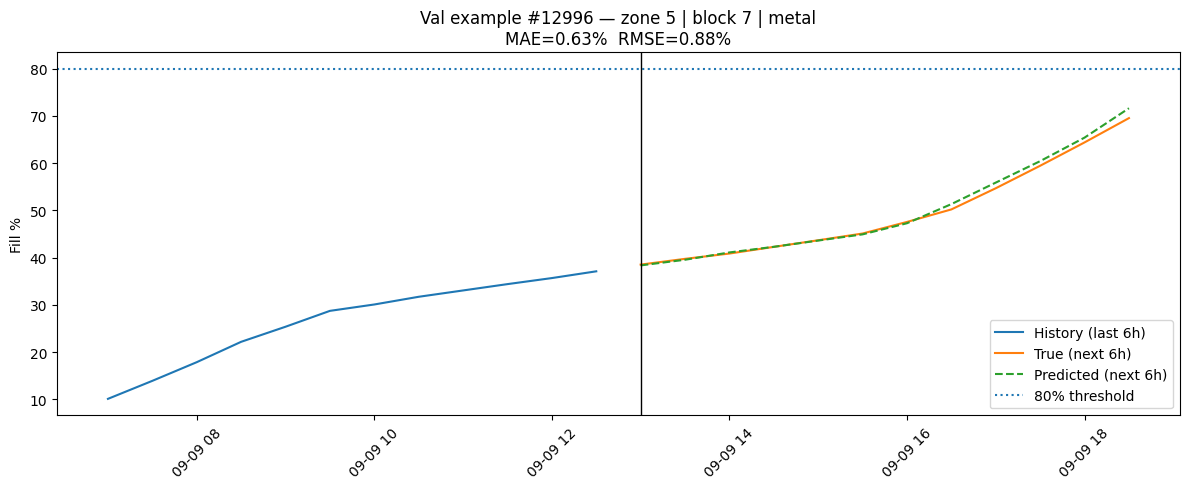

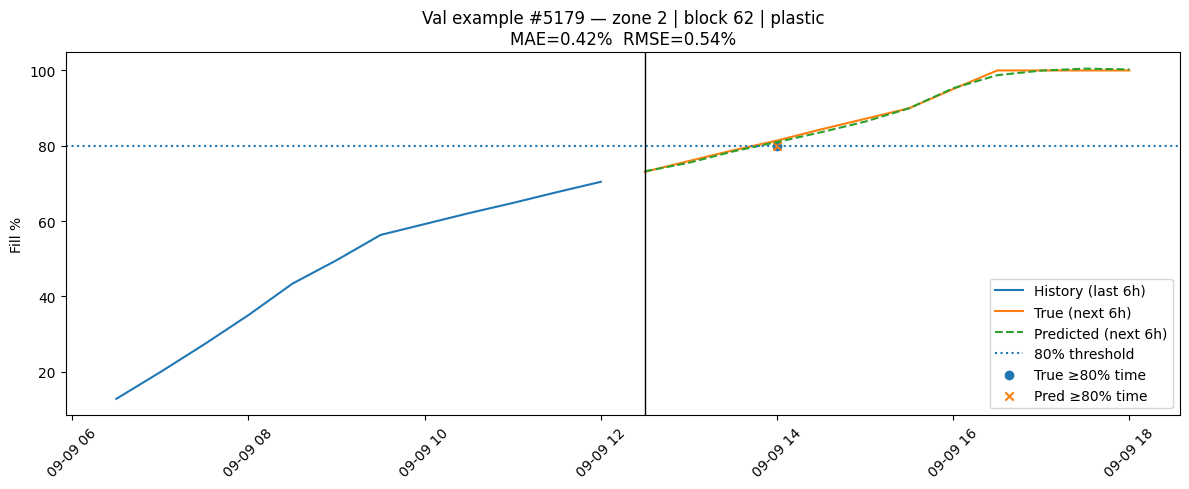

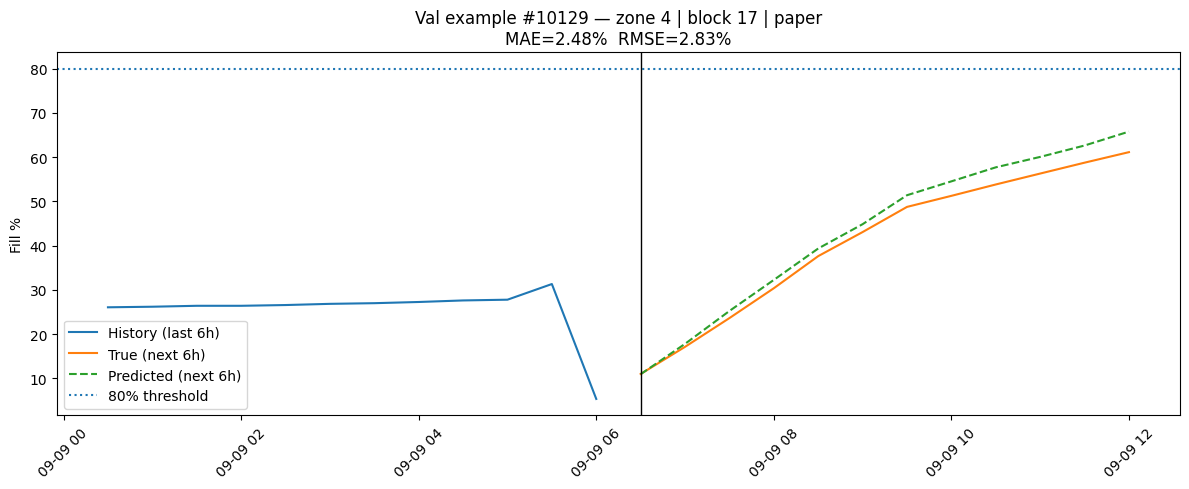

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Build a validation meta frame
meta_df = pd.DataFrame(meta_list)
meta_val = meta_df[is_val].reset_index(drop=True)

# Predict on validation set and inverse-scale
y_pred_val = model.predict(X_val, verbose=0)
y_pred_val_pct = scaler.inverse_transform(y_pred_val)
y_val_pct = scaler.inverse_transform(y_val)

def plot_val_example(k=0, threshold=80):
    """
    Plot one validation example k:
    - last 6h history (reconstructed from X_val)
    - true next 6h vs predicted next 6h
    - 80% threshold and vertical split
    """
    assert 0 <= k < len(X_val), "k out of range for validation set"
    hist_len = X_val.shape[1]
    horizon = y_val.shape[1]

    # Reconstruct history fill% (feature 0 in X_val is scaled)
    hist_scaled = X_val[k,:,0].reshape(-1,1)             # (12,1)
    hist_pct = scaler.inverse_transform(hist_scaled).ravel()

    # True & predicted futures (already computed above)
    y_true = y_val_pct[k]                                 # (12,)
    y_pred = y_pred_val_pct[k]                            # (12,)

    # Build time axis
    t0 = meta_val.loc[k, "start_time"]                    # first future step time
    times_hist = pd.date_range(t0 - pd.Timedelta(minutes=30*(hist_len)), periods=hist_len, freq="30min")
    times_fut  = pd.date_range(t0, periods=horizon, freq="30min")

    # Crossing indices (if any)
    idx_true = np.where(y_true >= threshold)[0]
    idx_pred = np.where(y_pred >= threshold)[0]
    t_true = times_fut[idx_true[0]] if len(idx_true) else None
    t_pred = times_fut[idx_pred[0]] if len(idx_pred) else None

    # Errors
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))

    plt.figure(figsize=(12,5))
    plt.plot(times_hist, hist_pct, label="History (last 6h)")
    plt.plot(times_fut, y_true, label="True (next 6h)")
    plt.plot(times_fut, y_pred, "--", label="Predicted (next 6h)")
    plt.axhline(threshold, linestyle=":", label=f"{threshold}% threshold")
    plt.axvline(t0, color="k", linewidth=1)
    plt.title(f"Val example #{k} — zone {meta_val.loc[k,'zone_id']} | block {meta_val.loc[k,'block_id']} | {meta_val.loc[k,'waste_type']}\nMAE={mae:.2f}%  RMSE={rmse:.2f}%")
    if t_true: plt.scatter([t_true],[threshold], marker="o", label="True ≥80% time")
    if t_pred: plt.scatter([t_pred],[threshold], marker="x", label="Pred ≥80% time")
    plt.legend()
    plt.xticks(rotation=45)
    plt.ylabel("Fill %")
    plt.tight_layout()
    plt.show()

# Try a few random validation examples
np.random.seed(0)
for k in np.random.choice(len(X_val), size=3, replace=False):
    plot_val_example(int(k))


## 🧪 Step 6 — Build Test Input Files (4 cases)

Create **CSV test inputs** for one zone at four moments of the day (morning, afternoon, evening, night).  
Each row = one block × waste type with its **last 12 steps** (`t_-11 … t_0`) of `fill_percent` at the chosen `target_time`.

**How it works**
- Picks blocks whose 12-step history ends exactly at `target_time` **without emptying inside**.
- If not enough blocks, synthesizes realistic histories as fallback.
- Optional `APPLY_STRESS=True` gently ramps the tail upward to induce crossings.

**Config**
- `ZONE_ID` (1–6), `BLOCKS_PER_TYPE` per waste type, `CASES` timestamps, `OUT_DIR`.

**Output**
- Four files like:  
  - `zone{ZONE_ID}_testinputs_morning.csv`  
  - `zone{ZONE_ID}_testinputs_afternoon.csv`  
  - `zone{ZONE_ID}_testinputs_evening.csv`  
  - `zone{ZONE_ID}_testinputs_night.csv`


In [9]:
# ==== CONFIG ====
ZONE_ID = 3                       # pick from {1..6}
BLOCKS_PER_TYPE = 100             # how many blocks per waste type to include
CASES = {
    "morning":   "2025-09-10 07:00:00",
    "afternoon": "2025-09-10 14:00:00",
    "evening":   "2025-09-10 18:00:00",
    "night":     "2025-09-10 02:00:00",
}
OUT_DIR = "/content"              # change if you want to save to Drive
APPLY_STRESS = False              # set True to gently ramp the last few steps

# ==== CODE ====
import numpy as np
import pandas as pd
from pathlib import Path

TYPE_NAMES = ["organic","plastic","paper","metal"]
HISTORY = 12

def _pick_blocks_with_clean_history(dft, target_time, k):
    """
    Return up to k (block_id, 12-step history) pairs where:
      - exact row at target_time exists
      - last 12 rows exist and have NO emptied in steps 1..10 (strictly inside)
    """
    out = []
    for bid, g in dft.groupby("block_id"):
        g = g[g["timestamp"] <= target_time].sort_values("timestamp")
        if len(g) < HISTORY or g.empty:
            continue
        if g["timestamp"].iloc[-1] != target_time:
            continue
        G = g.iloc[-HISTORY:]
        empt = G["emptied"].to_numpy()
        if empt[1:-1].any():  # skip if emptying strictly inside history
            continue
        hist = G["fill_percent"].to_numpy(dtype=float)
        if len(hist) == HISTORY:
            out.append((int(bid), hist))
        if len(out) >= k:
            break
    return out

def _apply_stress_upward(hist, max_boost_pp=1.2):
    """
    Gently increase the last few steps to create an upward slope (keeps within [0, 99.5]).
    """
    h = hist.copy().astype(float)
    tail_len = np.random.randint(4, 7)      # last 4..6 steps
    base = np.random.uniform(0.6, max_boost_pp)
    for i in range(len(h)-tail_len, len(h)-1):
        if h[i+1] < h[i]:
            h[i+1] = h[i] + abs(np.random.normal(0.2, 0.1))
        else:
            h[i+1] = h[i+1] + base * np.random.uniform(0.7, 1.3)
    return np.clip(h, 0, 99.5)

def _ensure_enough_rows_or_fallback(zone_id, waste_type, target_time, k):
    """
    Try to sample k blocks from df histories; if not enough, synthesize extra rows
    with a realistic range and optional stress tail (no emptying).
    """
    dft = df[(df["zone_id"]==zone_id) & (df["waste_type"]==waste_type)].copy()
    blocks = _pick_blocks_with_clean_history(dft, target_time, k)
    rows = []
    for bid, hist in blocks:
        rows.append((bid, hist))

    need = k - len(rows)
    if need > 0:
        # synthetic fallback histories around 50–75% with small drift (no emptying)
        rng = np.random.default_rng(42 + zone_id + len(rows))
        for j in range(need):
            # start near 55–70 at t_0 and diffuse backwards a bit
            t0 = rng.uniform(55, 70)
            seq = [t0]
            for _ in range(HISTORY-1):
                step = seq[-1] - rng.uniform(0.0, 0.7) + rng.normal(0, 0.35)
                seq.append(step)
            seq = list(reversed(seq))
            seq = np.clip(seq, 0, 99.5).astype(float)
            rows.append((-1000 - j, seq))  # negative block_id to mark synthetic
    return rows

def make_zone_case_files(zone_id, cases_dict, blocks_per_type=100, out_dir="/content", apply_stress=False):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    for case_name, ts in cases_dict.items():
        target_time = pd.Timestamp(ts)
        all_rows = []
        for wt in TYPE_NAMES:
            picked = _ensure_enough_rows_or_fallback(zone_id, wt, target_time, blocks_per_type)
            for bid, hist in picked:
                h = hist.copy()
                if apply_stress:
                    h = _apply_stress_upward(h)
                row = {
                    "zone_id": zone_id,
                    "block_id": int(bid),
                    "waste_type": wt,
                    "target_time": target_time.strftime("%Y-%m-%d %H:%M:%S"),
                }
                # write t_-11 ... t_0
                for i, val in enumerate(h, start=-HISTORY+1):
                    row[f"t_{i}"] = round(float(val), 2)
                all_rows.append(row)

        df_case = pd.DataFrame(all_rows)
        out_path = out_dir / f"zone{zone_id}_testinputs_{case_name}.csv"
        df_case.to_csv(out_path, index=False)
        print(f"Saved: {out_path}  shape={df_case.shape}")

# === Run it ===
make_zone_case_files(
    zone_id=ZONE_ID,
    cases_dict=CASES,
    blocks_per_type=BLOCKS_PER_TYPE,
    out_dir=OUT_DIR,
    apply_stress=APPLY_STRESS,   # set True if you want more crossings
)


Saved: /content/zone3_testinputs_morning.csv  shape=(400, 16)
Saved: /content/zone3_testinputs_afternoon.csv  shape=(400, 16)
Saved: /content/zone3_testinputs_evening.csv  shape=(400, 16)
Saved: /content/zone3_testinputs_night.csv  shape=(400, 16)


## 🚚 Step 7 — Truck Dispatch Simulation (OOS test files)

Use the model to **forecast the next 6h** for each case file and decide **when to send a truck**.

**What it does**
- Reads prepared case CSVs (last 12 steps per block/waste type).
- Rebuilds LSTM inputs (fill%, time features, zone/type one-hots) and **applies the same scaler**.
- Predicts 12 future steps (6h), **counts bins ≥ THRESHOLD** each step.
- Computes the **earliest dispatch time** when the count reaches the capacity equivalent:
  - assumes **50 L per bin**, so `bins_per_truck = TRUCK_CAP_L // 50`.

**Config**
- `THRESHOLD` (e.g., 80%), `TRUCK_CAP_L` (e.g., 4000 L), `CASE_PATHS` (files to test).

**Output (per waste type)**
- `bins ≥ THRESHOLD per step: [...]`
- `→ DISPATCH at <timestamp>` or `→ No truck needed in next 6h`.


In [10]:
import numpy as np
import pandas as pd

# ==== CONFIG (edit as needed) ====
ZONE_ID = 3
THRESHOLD = 80                # % full considered "ready"
TRUCK_CAP_L = 4000            # liters per truck
HISTORY = 12                  # last 6h history points (t_-11..t_0)
HORIZON = 12                  # next 6h
CASE_PATHS = {
    "afternoon": f"/content/zone{ZONE_ID}_testinputs_afternoon.csv",
}

# ==== CONSTANTS (same encoding as training) ====
TYPE_NAMES = ["organic","plastic","paper","metal"]
ZONE_IDS = [1,2,3,4,5,6]
Z = len(ZONE_IDS)
T = len(TYPE_NAMES)
zone_index = {z:i for i,z in enumerate(ZONE_IDS)}
type_index = {t:i for i,t in enumerate(TYPE_NAMES)}

def _time_feats_for_history(target_time, history=12):
    """(history, 4): hour_sin, hour_cos, dow_sin, dow_cos for t_-11..t_0 ending at target_time."""
    target_time = pd.Timestamp(target_time)
    times_hist = pd.date_range(target_time - pd.Timedelta(minutes=30*(history-1)),
                               periods=history, freq="30min")
    feats = []
    for t in times_hist:
        hour = t.hour + t.minute/60.0
        dow  = t.dayofweek
        feats.append([
            np.sin(2*np.pi*(hour/24.0)),
            np.cos(2*np.pi*(hour/24.0)),
            np.sin(2*np.pi*(dow/7.0)),
            np.cos(2*np.pi*(dow/7.0)),
        ])
    return np.array(feats), times_hist

def _prepare_X_from_oos(path_csv, history=12):
    """
    Read OOS file with columns:
      zone_id, block_id, waste_type, target_time, t_-11..t_0  (emptied optional/ignored)
    Build LSTM inputs of shape (N, history, 15) = [fill%, time4, zone6, type4].
    """
    df_case = pd.read_csv(path_csv)
    if df_case.empty:
        return np.empty((0, history, 15)), df_case

    tcols = [f"t_{i}" for i in range(-history+1, 1)]  # t_-11..t_0

    X_list = []
    for _, row in df_case.iterrows():
        zone_id = int(row["zone_id"])
        wt = str(row["waste_type"])
        target_time = pd.Timestamp(row["target_time"])

        # (history,1) fill%
        hist_vals = row[tcols].to_numpy(dtype=float).reshape(history,1)

        # (history,4) time feats
        tfeat, _ = _time_feats_for_history(target_time, history=history)

        # one-hots repeated per step
        z_oh = np.eye(Z)[zone_index[zone_id]]
        t_oh = np.eye(T)[type_index[wt]]
        z_rep = np.tile(z_oh, (history,1))
        t_rep = np.tile(t_oh, (history,1))

        # concat → (history, 15)
        X_win = np.concatenate([hist_vals, tfeat, z_rep, t_rep], axis=1)

        # scale only fill%
        X_win = X_win.copy()
        X_win[:, [0]] = scaler.transform(X_win[:, [0]])

        X_list.append(X_win)

    X_lstm = np.stack(X_list, axis=0) if X_list else np.empty((0, history, 15))
    return X_lstm, df_case

def _predict_counts_and_first_dispatch(X_lstm, meta, threshold=80, truck_capacity_l=2000, horizon=12):
    """
    For each waste type:
      - predict 12-step curves,
      - count bins >= threshold each step,
      - return earliest dispatch time when counts >= bins_per_truck.
    """
    results = {}
    if X_lstm.shape[0] == 0 or meta.empty:
        return results

    # Predict + inverse scale
    y_scaled = model.predict(X_lstm, verbose=0)          # (N, 12)
    y_pct    = scaler.inverse_transform(y_scaled)        # (N, 12)
    y_pct    = np.clip(y_pct, 0, 100)

    # All rows in a file share target_time
    target_time = pd.Timestamp(meta["target_time"].iloc[0])
    future_times = pd.date_range(target_time, periods=horizon, freq="30min")

    # bins per truck (50 L per bin)
    bins_per_truck = max(1, int(truck_capacity_l // 50))

    # Process by waste type
    for wt in TYPE_NAMES:
        mask = (meta["waste_type"] == wt).to_numpy()
        if mask.sum() == 0:
            continue

        y_wt = y_pct[mask]                            # (N_wt, 12)
        counts = (y_wt >= threshold).sum(axis=0).tolist()

        # earliest dispatch time
        dispatch_time = None
        for j, c in enumerate(counts):
            if c >= bins_per_truck:
                dispatch_time = future_times[j]
                break

        results[wt] = {
            "counts": counts,
            "dispatch_time": dispatch_time,
            "bins_considered": int(mask.sum()),
            "future_times": future_times
        }
    return results

def test_case_file(path_csv, threshold=THRESHOLD, truck_capacity_l=TRUCK_CAP_L,
                   history=HISTORY, horizon=HORIZON):
    X_lstm, meta = _prepare_X_from_oos(path_csv, history=history)
    if meta.empty:
        print(f"\n{path_csv}: file empty.")
        return

    z = int(meta['zone_id'].iloc[0])
    ts = pd.Timestamp(meta['target_time'].iloc[0])

    print(f"\n=== TEST — Zone {z} — start {ts} ===")
    print(f"(Step = 30 min; 0..{horizon-1} cover next 6 hours)  |  threshold={threshold}%  |  capacity={truck_capacity_l}L\n")

    res = _predict_counts_and_first_dispatch(
        X_lstm, meta, threshold=threshold, truck_capacity_l=truck_capacity_l, horizon=horizon
    )

    for wt in TYPE_NAMES:
        if wt not in res:
            continue
        counts = res[wt]["counts"]
        tdisp  = res[wt]["dispatch_time"]
        nb     = res[wt]["bins_considered"]
        print(f"[{wt}]  (bins considered: {nb})")
        print(f"  bins ≥ {threshold}% per step: {counts}")
        if tdisp is not None:
            print(f"  → DISPATCH at {tdisp}")
        else:
            print("  → No truck needed in next 6h")
        print()

# === Run the 4 case files ===
for name, p in CASE_PATHS.items():
    test_case_file(p, threshold=THRESHOLD, truck_capacity_l=TRUCK_CAP_L)



=== TEST — Zone 3 — start 2025-09-10 14:00:00 ===
(Step = 30 min; 0..11 cover next 6 hours)  |  threshold=80%  |  capacity=4000L

[organic]  (bins considered: 100)
  bins ≥ 80% per step: [0, 0, 0, 12, 45, 90, 100, 100, 100, 100, 100, 0]
  → DISPATCH at 2025-09-10 16:30:00

[plastic]  (bins considered: 100)
  bins ≥ 80% per step: [0, 0, 0, 9, 43, 90, 100, 100, 100, 100, 100, 0]
  → DISPATCH at 2025-09-10 16:30:00

[paper]  (bins considered: 100)
  bins ≥ 80% per step: [0, 0, 0, 9, 43, 88, 100, 100, 100, 100, 100, 0]
  → DISPATCH at 2025-09-10 16:30:00

[metal]  (bins considered: 100)
  bins ≥ 80% per step: [0, 0, 0, 10, 44, 85, 100, 100, 100, 100, 100, 0]
  → DISPATCH at 2025-09-10 16:30:00



In [12]:
# =========================
# Save & Download Trained Model + Artifacts  (Keras 3 compatible)
# =========================
import os, json, zipfile, datetime, pathlib, sys
import joblib
import tensorflow as tf

SAVE_DIR = "/content/bin_forecast_export"   # change if needed
pathlib.Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

# 1) Save Keras model (single file)
keras_path = os.path.join(SAVE_DIR, "sfax_lstm_model.keras")
model.save(keras_path)

# 1b) Export a SavedModel (Keras 3: use model.export; fallback for older Keras)
savedmodel_dir = os.path.join(SAVE_DIR, "sfax_lstm_savedmodel")
saved_ok = False
try:
    # Keras 3 provides .export for TF SavedModel inference format
    if hasattr(model, "export"):
        model.export(savedmodel_dir)
        saved_ok = True
    else:
        # Older TF/Keras stacks still allow tf.saved_model.save
        tf.saved_model.save(model, savedmodel_dir)
        saved_ok = True
except Exception as e:
    print("[WARN] Could not export SavedModel:", e)
    print("       The .keras file is still saved and is the recommended format.")

# 2) Save scaler + minimal metadata
joblib.dump(scaler, os.path.join(SAVE_DIR, "scaler.joblib"))

meta = {
    "created_at_utc": datetime.datetime.utcnow().isoformat() + "Z",
    "hist_len": int(X_train.shape[1]),
    "n_features": int(X_train.shape[2]),
    "horizon": int(y_train.shape[1]),
    "threshold_default": 80,
    "zone_ids": sorted(list(map(int, set(meta_df['zone_id'].values)))) if 'meta_df' in globals() else [1,2,3,4,5,6],
    "waste_types": ["organic","plastic","paper","metal"],
    "feature_order_hist": ["fill_percent","hour_sin","hour_cos","dow_sin","dow_cos",
                           "zone_onehot(6)","type_onehot(4)"],
}
with open(os.path.join(SAVE_DIR, "model_meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

# 3) Tiny README
readme = f"""\
Sfax LSTM Bin Forecast — Export
===============================

Files:
- sfax_lstm_model.keras         (Keras single-file model)  ✅
- {'sfax_lstm_savedmodel/ (TensorFlow SavedModel)' if saved_ok else '(SavedModel export failed — see warning)'}
- scaler.joblib                 (MinMaxScaler for fill_percent)
- model_meta.json               (shapes & feature order)

Notes:
- Only 'fill_percent' was scaled (feature index 0). Others are raw.
- History = {meta['hist_len']} steps (30 min), Horizon = {meta['horizon']} steps.
- Rebuild inputs exactly like training: [fill%, hour_sin, hour_cos, dow_sin, dow_cos, zone6, type4].

Load example:
-------------
import joblib, tensorflow as tf, json
scaler = joblib.load("scaler.joblib")
model  = tf.keras.models.load_model("sfax_lstm_model.keras")
with open("model_meta.json") as f: meta = json.load(f)
"""
with open(os.path.join(SAVE_DIR, "README.txt"), "w") as f:
    f.write(readme)

# 4) Zip everything for one-click download
zip_path = os.path.join(SAVE_DIR, "sfax_lstm_export.zip")
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    z.write(keras_path, arcname="sfax_lstm_model.keras")
    z.write(os.path.join(SAVE_DIR, "scaler.joblib"), arcname="scaler.joblib")
    z.write(os.path.join(SAVE_DIR, "model_meta.json"), arcname="model_meta.json")
    z.write(os.path.join(SAVE_DIR, "README.txt"), arcname="README.txt")
    if saved_ok:
        for root, _, files in os.walk(savedmodel_dir):
            for fn in files:
                full = os.path.join(root, fn)
                rel  = os.path.relpath(full, SAVE_DIR)
                z.write(full, arcname=rel)

print("Saved to:", SAVE_DIR)
print(" -", keras_path)
print(" -", zip_path)
if saved_ok:
    print(" -", savedmodel_dir)

# 5) Trigger download in Colab (or show a link in Jupyter)
try:
    from google.colab import files
    files.download(zip_path)
except Exception:
    try:
        from IPython.display import FileLink, display
        display(FileLink(zip_path))
    except:
        pass


Saved artifact at '/content/bin_forecast_export/sfax_lstm_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 12, 15), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  132387544855376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132387544856912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132387544856720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132387544857872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132387544857680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132387544855760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132387544858448: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved to: /content/bin_forecast_export
 - /content/bin_forecast_export/sfax_lstm_model.keras
 - /content/bin_forecast_export/sfax_lstm_export.zip
 - /content/bin_forecast_export/sfax_lstm_savedmode

/tmp/ipython-input-721945427.py:35: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at_utc": datetime.datetime.utcnow().isoformat() + "Z",


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>